In [1]:
import pandas
import datetime
import numpy
import scipy.optimize
from scipy.stats import linregress, norm
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import bs4
import urllib
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from davitpy import gme
%matplotlib inline

In [2]:
# Some constants
cutOffMLTMLATUniqCnt = 4

In [3]:
#Let's set a start and end date...
sTime = datetime.datetime(2011,1,1)
eTime = datetime.datetime(2014,12,31)
omnData=gme.ind.omni.readOmni(sTime, eTime)

In [4]:
omnDF = pandas.DataFrame( {'date' : [ omnData[x].time for x in range(len(omnData))],
                          'Bz' : [ omnData[x].bzm for x in range(len(omnData))] }
                        ) 
omnDF["hour"] = omnDF["date"].apply(lambda x: x.strftime('%H'))
omnDF["minute"] = omnDF["date"].apply(lambda x: x.strftime('%M'))
omnDF["dtStr"] = omnDF["date"].apply(lambda x: x.strftime('%Y%m%d'))

In [5]:
velsDataDF = pandas.read_csv( "../data/processed-vels-geomag-fin.txt", sep=' ',\
                            infer_datetime_format=True,\
                            parse_dates=["date"])
# Get actual SAPS azimuths
velsDataDF["azim"] = -90.-velsDataDF["azim"]
velsDataDF.head()
# Filter out some values
# When there aren't good number of measurements at lats
# discard those values
cntMLTPntsDF = velsDataDF[ ["dst_bin", "normMLT", "MLAT"] \
                    ].groupby( ["dst_bin", "normMLT"] \
                    )["MLAT"].nunique().reset_index()
cntMLTPntsDF.columns = ["dst_bin", "normMLT", "MLATCntUnq"]
cntMLTPntsDF = cntMLTPntsDF[ cntMLTPntsDF["MLATCntUnq"] >=\
                    cutOffMLTMLATUniqCnt ][ ["dst_bin", "normMLT"]\
                        ].reset_index(drop=True)
velsDataDF = pandas.merge( velsDataDF, cntMLTPntsDF,\
                    on=["dst_bin", "normMLT"], how="inner" )
velsDataDF["hour"] = velsDataDF["date"].apply(lambda x: x.strftime('%H'))
velsDataDF["minute"] = velsDataDF["date"].apply(lambda x: x.strftime('%M'))
velsDataDF["dtStr"] = velsDataDF["date"].apply(lambda x: x.strftime('%Y%m%d'))

In [6]:
# Also merge with aymDF
# print "pre merge shape-->", velsDataDF.shape
velsDataDF = pandas.merge( velsDataDF, omnDF,\
                         on=["dtStr", "hour", "minute"], how='inner')
velsDataDF.head()
# velsDataDF = velsDataDF [ ['azim','azimStd', 'delMLT', 'goodFit',\
#                       'MLAT', 'normMLT', 'vSaps', 'velSTD',\
#                       'endPtMLAT', 'endPtNormMLT', 'date_x','dtStr',\
#                       'hour', 'minute', 'dst_date', 'dst_index', 'dst_bin',\
#                       'datetimeStr_x', 'AE', 'AL', 'AO', 'AU', 'count', 'maxCount',\
#                        'probOcc', 'AsyD', 'AsyH', 'SymD', 'SymH'] ]
# velsDataDF.columns = ['azim','azimStd', 'delMLT', 'goodFit',\
#                       'MLAT', 'normMLT', 'vSaps', 'velSTD',\
#                       'endPtMLAT', 'endPtNormMLT', 'date','dtStr',\
#                       'hour', 'minute', 'dst_date', 'dst_index', 'dst_bin',\
#                       'datetimeStr', 'AE', 'AL', 'AO', 'AU', 'count', 'maxCount',\
#                        'probOcc', 'AsyD', 'AsyH', 'SymD', 'SymH']

,azim,azimStd,delMLT,goodFit,MLAT,normMLT,vSaps,velSTD,endPtMLAT,endPtNormMLT,...,datetimeStr,AE,AL,AO,AU,count,maxCount,probOcc,Bz,date_y
0,-79.412573,1.794202,0.5,True,62.0,-6.0,306.738497,11.198685,62.06,-6.30,...,20121014-01-00,500,-343,-93,157,470,2562,0.183450,-1.94,2012-10-14 01:00:00
1,-78.075135,1.005434,0.5,True,61.5,-6.0,296.893207,6.211472,61.56,-6.29,...,20121014-01-00,500,-343,-93,157,572,2562,0.223263,-1.94,2012-10-14 01:00:00
2,-82.467569,3.532155,0.5,True,60.0,-6.0,220.239731,11.464162,60.03,-6.22,...,20121014-01-00,500,-343,-93,157,554,2562,0.216237,-1.94,2012-10-14 01:00:00
3,-84.987310,1.491959,0.5,True,60.5,-6.0,233.815511,5.963564,60.52,-6.23,...,20121014-01-00,500,-343,-93,157,566,2562,0.220921,-1.94,2012-10-14 01:00:00
4,-79.086184,0.914397,0.5,True,62.5,-6.0,343.746070,6.854657,62.57,-6.34,...,20121014-01-00,500,-343,-93,157,494,2562,0.192818,-1.94,2012-10-14 01:00:00


In [7]:
# # Divide asymH index into bins
# asyHBins = [ 0, 30, 60, 90, 180 ]
# velsDataDF = pandas.concat( [ velsDataDF, \
#                     pandas.cut( velsDataDF["AsyH"], \
#                                bins=asyHBins ) ], axis=1 )
# velsDataDF.columns = ['azim','azimStd', 'delMLT', 'goodFit',\
#                       'MLAT', 'normMLT', 'vSaps', 'velSTD',\
#                       'endPtMLAT', 'endPtNormMLT', 'date','dtStr',\
#                       'hour', 'minute', 'dst_date', 'dst_index', 'dst_bin',\
#                       'datetimeStr', 'AE', 'AL', 'AO', 'AU', 'count', 'maxCount',\
#                        'probOcc', 'AsyD', 'AsyH', 'SymD', 'SymH', 'AsyH_bin']

In [8]:
# # Divide velocities into bins
# velBins = [ 0, 200, 500, 1000, 2000 ]
# velsDataDF = pandas.concat( [ velsDataDF, \
#                     pandas.cut( velsDataDF["vSaps"], \
#                                bins=velBins ) ], axis=1 )
# velsDataDF.columns = ['azim','azimStd', 'delMLT', 'goodFit',\
#                       'MLAT', 'normMLT', 'vSaps', 'velSTD',\
#                       'endPtMLAT', 'endPtNormMLT', 'date','dtStr',\
#                       'hour', 'minute', 'dst_date', 'dst_index', 'dst_bin',\
#                       'datetimeStr', 'AE', 'AL', 'AO', 'AU', 'count', 'maxCount',\
#                        'probOcc', 'AsyD', 'AsyH', 'SymD', 'SymH', 'AsyH_bin', 'vel_bin']

In [9]:
# velBinMeanDF = velsDataDF.groupby( "vel_bin" ).max()
# binCols = [ 'MLAT', 'normMLT', 'vSaps', 'dst_index', 'AE', 'AL', 'AO', 'AU', 'count', 'AsyH', 'SymH' ]
# velBinMeanDF[binCols].head()
velsDataDF.columns

Index([u'azim', u'azimStd', u'delMLT', u'goodFit', u'MLAT', u'normMLT',
       u'vSaps', u'velSTD', u'endPtMLAT', u'endPtNormMLT', u'date_x', u'dtStr',
       u'hour', u'minute', u'dst_date', u'dst_index', u'dst_bin',
       u'datetimeStr', u'AE', u'AL', u'AO', u'AU', u'count', u'maxCount',
       u'probOcc', u'Bz', u'date_y'],
      dtype='object')

In [10]:
velsDataDF = velsDataDF.dropna()
# lowVelSAPS = velsDataDF[ (velsDataDF["vSaps"] <= 300.) &\
#                        (velsDataDF["normMLT"] >= -2.) &\
#                        (velsDataDF["dst_index"] >= -25.) ].reset_index(drop=True)
# highVelSAPS = velsDataDF[ (velsDataDF["vSaps"] >= 500.) &\
#                        (velsDataDF["normMLT"] <= 2.)&\
#                        (velsDataDF["dst_index"] <= -50.) ].reset_index(drop=True)
lowVelSAPS = velsDataDF[ (velsDataDF["dst_index"] >= -25.) ].reset_index(drop=True)
highVelSAPS = velsDataDF[ (velsDataDF["dst_index"] <= -50.) ].reset_index(drop=True)

In [11]:
print lowVelSAPS[ ["Bz"] ].mean(), lowVelSAPS[ ["Bz"] ].std()
print highVelSAPS[ ["Bz"] ].mean(), highVelSAPS[ ["Bz"] ].std()

Bz   -0.598075
dtype: float64 Bz    3.076423
dtype: float64
Bz   -3.409302
dtype: float64 Bz    5.808261
dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f1de78910>]], dtype=object)

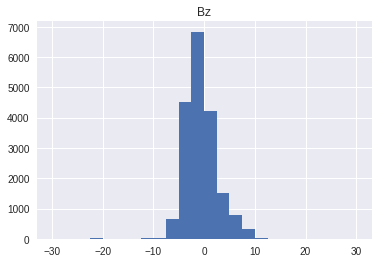

In [12]:
bins = numpy.arange(-30.,32.5,2.5)#[-30, -20, -15, -10, -5, -2.5, 0, 2.5, 5, 10, 15, 20, 30]
lowVelSAPS[ ["Bz"] ].hist(bins=bins)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f8c47f2d0>]], dtype=object)

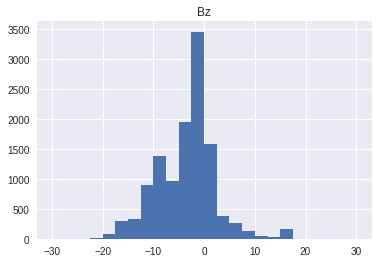

In [13]:
highVelSAPS[ ["Bz"] ].hist(bins=bins)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f1aada3d0>]], dtype=object)

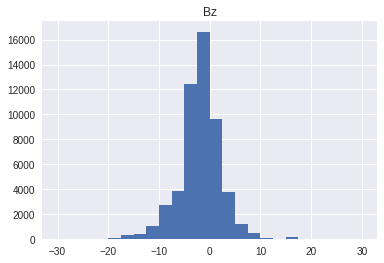

In [14]:
velsDataDF[ ["Bz"] ].hist(bins=bins)

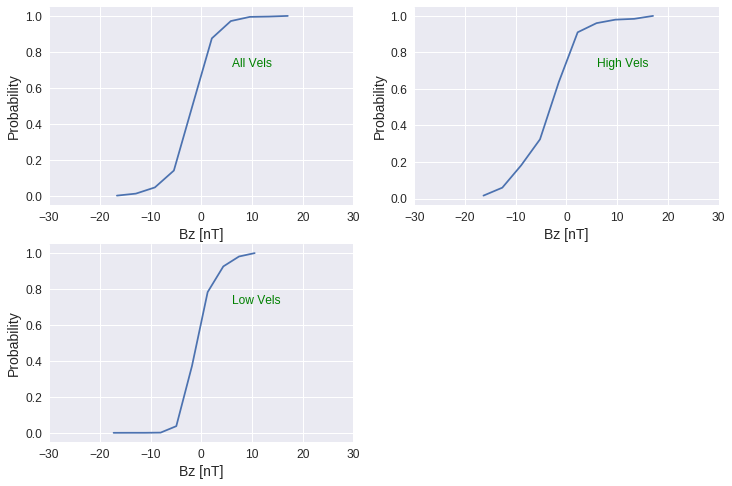

In [15]:
f = plt.figure(figsize=(12, 8))
axArr = []
axArr.append( f.add_subplot(2,2,1) )
axArr.append( f.add_subplot(2,2,2) )
axArr.append( f.add_subplot(2,2,3) ) 

currHistAllVels, currBndAllVels = numpy.histogram(velsDataDF["Bz"].values, normed=True)
currCDFAllVels = numpy.cumsum(currHistAllVels) * ( currBndAllVels[1] - currBndAllVels[0] )
currHistLowVels, currBndLowVels = numpy.histogram(lowVelSAPS["Bz"].values, normed=True)
currCDFLowVels = numpy.cumsum(currHistLowVels) * ( currBndLowVels[1] - currBndLowVels[0] )
currHistHighVels, currBndHighVels = numpy.histogram(highVelSAPS["Bz"].values, normed=True)
currCDFHighVels = numpy.cumsum(currHistHighVels) * ( currBndHighVels[1] - currBndHighVels[0] )
for ind, ax in enumerate(axArr):
    ax.set_xlabel("Bz [nT]", fontsize=14)
    ax.set_ylabel("Probability", fontsize=14)
    if ind == 0:
        ax.plot( currBndAllVels[1:], currCDFAllVels )
        ax.text(0.6, 0.7,  "All Vels",
            transform=ax.transAxes,
            color='green', fontsize=12)
    if ind == 1:
        ax.plot( currBndHighVels[1:], currCDFHighVels )
        ax.text(0.6, 0.7,  "High Vels",
            transform=ax.transAxes,
            color='green', fontsize=12)
    if ind == 2:
        ax.plot( currBndLowVels[1:], currCDFLowVels )
        ax.text(0.6, 0.7,  "Low Vels",
            transform=ax.transAxes,
            color='green', fontsize=12)
    ax.tick_params(labelsize=12)
    ax.set_xlim( [-30,30] )

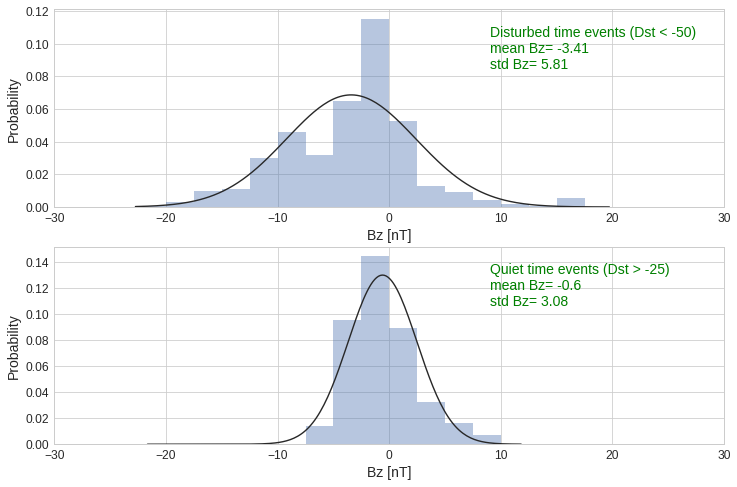

In [16]:
sns.set_style("whitegrid")
sns.set_context("paper")


f = plt.figure(figsize=(12, 8))
axArr = []
axArr.append( f.add_subplot(2,1,1) )
axArr.append( f.add_subplot(2,1,2) ) 


for ind, ax in enumerate(axArr):
    ax.set_xlabel("Bz [nT]", fontsize=14)
    ax.set_ylabel("Probability", fontsize=14)
#     if ind == 0:
#         sns.distplot( velsDataDF["Bz"].values,ax=ax, hist=True, bins=bins, fit=norm, kde=False )
#         ax.text(0.6, 0.7,  "All Vels",
#             transform=ax.transAxes,
#             color='green', fontsize=12)
    if ind == 0:
        printText = "Disturbed time events (Dst < -50)" + "\n" + "mean Bz= " +\
                    str(round(highVelSAPS["Bz"].mean(),2)) + "\n" +\
                    "std Bz= " + str(round(highVelSAPS["Bz"].std(),2))
        sns.distplot( highVelSAPS["Bz"].values,ax=ax, hist=True, bins=bins, fit=norm, kde=False )
        ax.text(0.65, 0.7,  printText,
            transform=ax.transAxes,
            color='green', fontsize=14)
    if ind == 1:
        printText = "Quiet time events (Dst > -25)" + "\n" + "mean Bz= " +\
                    str(round(lowVelSAPS["Bz"].mean(),2)) + "\n" +\
                    "std Bz= " + str(round(lowVelSAPS["Bz"].std(),2))
        sns.distplot( lowVelSAPS["Bz"].values,ax=ax, hist=True, bins=bins, fit=norm, kde=False )
        ax.text(0.65, 0.7,  printText,
            transform=ax.transAxes,
            color='green', fontsize=14)
    ax.tick_params(labelsize=12)
    ax.set_xlim( [-30,30] )
    

f.savefig("../figs/lowVel-highVel-Bz.pdf",bbox_inches='tight')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f2217d5d0>]], dtype=object)

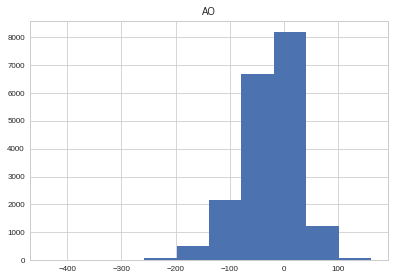

In [17]:
AObins=range( -700,100,50 )
lowVelSAPS[ ["AO"] ].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f185e1f90>]], dtype=object)

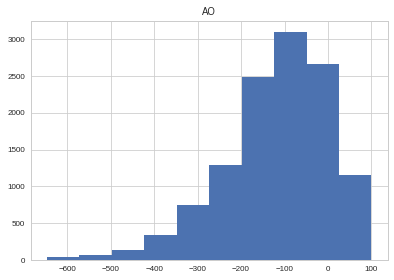

In [18]:
highVelSAPS[ ["AO"] ].hist()